Top 5 collaborative product recommendations for user 266783:
 prod_cat          prod_subcat
Electronics       Computers      1.368258
Clothing          Kids           1.212041
Home and kitchen  Furnishing     0.825129
                  Bath           0.778332
                  Tools          0.734618
Name: 266783, dtype: float64
Top 5 content-based product recommendations for user 266783:
        prod_cat_Bags  prod_cat_Books  prod_cat_Clothing  prod_cat_Electronics  \
5888           False           False              False                 False   
4737           False           False              False                 False   
2034           False           False               True                 False   
15477          False           False              False                 False   
15468          False           False               True                 False   

       prod_cat_Footwear  prod_cat_Home and kitchen  prod_subcat_Academic  \
5888                True                   

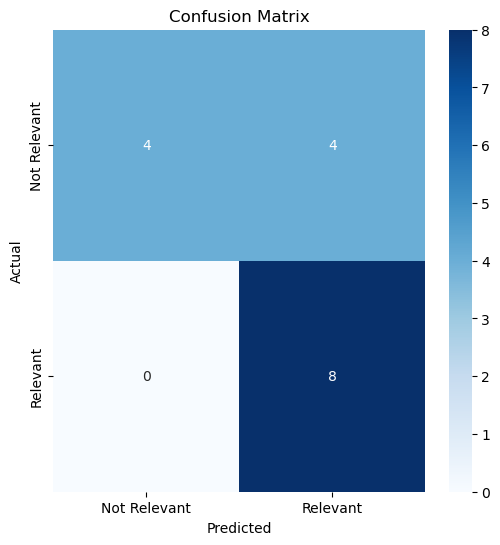

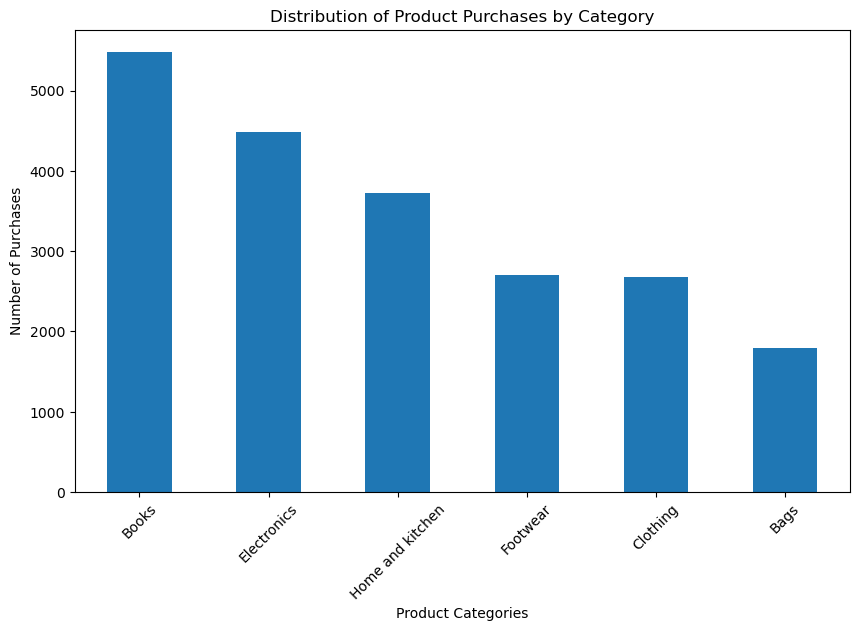

=== Collaborative Recommendations ===
prod_cat          prod_subcat
Electronics       Computers      1.368258
Clothing          Kids           1.212041
Home and kitchen  Furnishing     0.825129
                  Bath           0.778332
                  Tools          0.734618

=== Content-Based Recommendations ===
 prod_cat_Bags  prod_cat_Books  prod_cat_Clothing  prod_cat_Electronics
         False           False              False                 False
         False           False              False                 False
         False           False               True                 False
         False           False              False                 False
         False           False               True                 False

=== Hybrid Recommendations ===
prod_cat          prod_subcat
Home and kitchen  Tools          971
Electronics       Mobiles        947
Footwear          Women          943
Books             Fiction        939
                  Children       933

===

In [1]:
# ============================= 
# 1. Import Libraries
# =============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# ============================= 
# 2. Data Merging and Cleaning
# =============================

# Load data
customer_df = pd.read_csv("Customer.csv")
transactions_df = pd.read_csv("Transactions.csv")
prod_cat_info_df = pd.read_csv("prod_cat_info.csv")

# Merge datasets
merged_df = pd.merge(transactions_df, prod_cat_info_df, left_on=['prod_cat_code', 'prod_subcat_code'],
                     right_on=['prod_cat_code', 'prod_sub_cat_code'], how='left')
merged_df.drop(columns=['prod_sub_cat_code'], inplace=True)

# Convert negative quantities and rates to positive
merged_df['Qty'] = merged_df['Qty'].abs()
merged_df['Rate'] = merged_df['Rate'].abs()
merged_df['total_amt'] = merged_df['total_amt'].abs()

# Merge with customer data
final_merged_df = pd.merge(merged_df, customer_df, how='inner', left_on='cust_id', right_on='customer_Id')
final_merged_df.drop(columns=['customer_Id'], inplace=True)

# Remove duplicate transaction IDs
final_merged_df = final_merged_df.drop_duplicates(subset='transaction_id', keep='first')

# Remove missing values
final_merged_df_cleaned = final_merged_df.dropna()
new_column_order = ['transaction_id', 'tran_date', 'cust_id', 'DOB', 'Gender', 'city_code', 'prod_cat', 
                    'prod_cat_code', 'prod_subcat', 'prod_subcat_code', 'Store_type', 'Qty', 'Rate', 
                    'Tax', 'total_amt']
final_merged_df_cleaned = final_merged_df_cleaned[new_column_order]

# Save cleaned data to CSV
final_merged_df_cleaned.to_csv('final_merged_cleaned_data.csv', index=False)

# ============================= 
# 3. Data Preprocessing
# =============================

# Load cleaned data
df = pd.read_csv('final_merged_cleaned_data.csv')

# Convert 'tran_date' and 'DOB' to datetime format
df['tran_date'] = pd.to_datetime(df['tran_date'], format='%d-%m-%Y', errors='coerce')
df['DOB'] = pd.to_datetime(df['DOB'], format='%d-%m-%Y', errors='coerce')

# Create 'age' column from 'DOB'
df['age'] = (pd.to_datetime('today') - df['DOB']).dt.days // 365

# Handle missing city codes
df['city_code'] = df['city_code'].fillna(df['city_code'].median())

# Remove rows with critical missing data
data_cleaned = df.dropna(subset=['tran_date', 'cust_id', 'prod_cat', 'prod_subcat', 'Store_type', 'total_amt'])

# ============================= 
# 4. Collaborative Filtering
# =============================

# Create the user-item interaction matrix
user_item_matrix = data_cleaned.pivot_table(index='cust_id', 
                                            columns=['prod_cat', 'prod_subcat'], 
                                            values='Qty', 
                                            aggfunc='sum', 
                                            fill_value=0)

# Apply SVD for collaborative filtering
svd = TruncatedSVD(n_components=10, random_state=42)
user_item_matrix_svd = svd.fit_transform(user_item_matrix)

# Reconstruct the approximate user-item matrix
user_item_matrix_approx = np.dot(user_item_matrix_svd, svd.components_)
user_item_matrix_approx_df = pd.DataFrame(user_item_matrix_approx, 
                                          index=user_item_matrix.index, 
                                          columns=user_item_matrix.columns)

# Recommend products using collaborative filtering
def recommend_products(user_id, n=5):
    user_interactions = user_item_matrix.loc[user_id]
    user_predictions = user_item_matrix_approx_df.loc[user_id]
    user_unseen_products = user_predictions[user_interactions == 0]
    top_recommendations = user_unseen_products.sort_values(ascending=False).head(n)
    return top_recommendations

# Example: Recommend top 5 products for user 266783
user_id = 266783
top_collab_recommendations = recommend_products(user_id, n=5)
print(f"Top 5 collaborative product recommendations for user {user_id}:\n", top_collab_recommendations)

# ============================= 
# 5. Content-Based Filtering
# =============================

# One-hot encode product categories and subcategories
product_features = data_cleaned[['prod_cat', 'prod_subcat']]
product_feature_matrix = pd.get_dummies(product_features, columns=['prod_cat', 'prod_subcat'])

# Create user profiles
user_profiles = pd.DataFrame(0, index=data_cleaned['cust_id'].unique(), columns=product_feature_matrix.columns)
for _, row in data_cleaned.iterrows():
    cust_id = row['cust_id']
    prod_cat = f"prod_cat_{row['prod_cat']}"
    prod_subcat = f"prod_subcat_{row['prod_subcat']}"
    
    if prod_cat in user_profiles.columns:
        user_profiles.at[cust_id, prod_cat] += row['Qty']
        
    if prod_subcat in user_profiles.columns:
        user_profiles.at[cust_id, prod_subcat] += row['Qty']

# Calculate the cosine similarity between user profiles and product feature matrix
similarity_matrix = cosine_similarity(user_profiles, product_feature_matrix)
similarity_df = pd.DataFrame(similarity_matrix, index=user_profiles.index, columns=product_feature_matrix.index)

# Recommend products using content-based filtering
def recommend_content_based(user_id, n=5):
    user_similarities = similarity_df.loc[user_id]
    top_product_indices = user_similarities.sort_values(ascending=False).head(n).index
    return product_feature_matrix.iloc[top_product_indices]

# Example: Recommend top 5 products for user 266783
top_content_recommendations = recommend_content_based(user_id, n=5)
print(f"Top 5 content-based product recommendations for user {user_id}:\n", top_content_recommendations)

# ============================= 
# 6. Hybrid Model
# =============================

# Define weights for each model
collab_weight = 0.6
content_weight = 0.4

# Function to get popular products
def get_popular_products(n=5):
    popular_products = data_cleaned.groupby(['prod_cat', 'prod_subcat']).size().nlargest(n)
    return popular_products

# Function to create a hybrid recommendation
def hybrid_recommendations(user_id, n=5):
    if user_id not in user_item_matrix_approx_df.index:
        print(f"User {user_id} not found in collaborative filtering data. Returning popular items.")
        return get_popular_products(n)

    if user_id not in similarity_df.index:
        print(f"User {user_id} not found in content-based filtering data. Returning popular items.")
        return get_popular_products(n)

    user_collab_scores = user_item_matrix_approx_df.loc[user_id]
    user_content_scores = similarity_df.loc[user_id]

    common_products = user_collab_scores.index.intersection(user_content_scores.index)

    if len(common_products) == 0:
        print(f"No common products found for user {user_id}. Returning popular items.")
        return get_popular_products(n)

    hybrid_scores = (collab_weight * user_collab_scores[common_products]) + (content_weight * user_content_scores[common_products])
    top_product_indices = hybrid_scores.sort_values(ascending=False).head(n).index
    recommendations = product_feature_matrix.loc[top_product_indices]
    return recommendations

# Example: Hybrid recommendations for user 266783
top_hybrid_recommendations = hybrid_recommendations(user_id=user_id, n=5)
print(f"Top 5 hybrid product recommendations for user {user_id}:\n", top_hybrid_recommendations)

# ============================= 
# 7. Evaluation Metrics
# =============================

# Simulated validation data (ground truth) for user-item interactions
validation_user_item_matrix = np.array([
    [1, 0, 1, 0],  # User 0 (interacted with item 0 and 2)
    [0, 1, 0, 1],  # User 1 (interacted with item 1 and 3)
    [1, 1, 0, 0],  # User 2 (interacted with item 0 and 1)
    [0, 0, 1, 1],  # User 3 (interacted with item 2 and 3)
])

# Function to calculate evaluation metrics
def calculate_evaluation_metrics(validation_matrix, recommendations):
    precision_list = []
    recall_list = []
    f1_list = []
    
    for user_idx in range(validation_matrix.shape[0]):
        true_labels = validation_matrix[user_idx]
        pred_labels = np.zeros_like(true_labels)
        
        # Mark the recommended items
        for item in recommendations[user_idx]:
            if item < len(pred_labels):
                pred_labels[item] = 1
        
        precision = precision_score(true_labels, pred_labels)
        recall = recall_score(true_labels, pred_labels)
        f1 = f1_score(true_labels, pred_labels)
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
    
    # Average metrics
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)
    
    return avg_precision, avg_recall, avg_f1

# Run evaluation with simulated recommendations
# Adjust this according to how you store your recommendations for each user
# For simplicity, assume hybrid recommendations are just indices of recommended items
hybrid_recommendations = np.array([
    [0, 2, 3],  # Recommendations for User 0
    [1, 3, 2],  # Recommendations for User 1
    [0, 1, 3],  # Recommendations for User 2
    [2, 3, 0]   # Recommendations for User 3
])

# Calculate evaluation metrics
avg_precision, avg_recall, avg_f1 = calculate_evaluation_metrics(validation_user_item_matrix, hybrid_recommendations)
print("Evaluation Metrics (Precision, Recall, F1-Score):", (avg_precision, avg_recall, avg_f1))

# ============================= 
# 8. Visualizations
# =============================

# Visualization of confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Relevant', 'Relevant'],
                yticklabels=['Not Relevant', 'Relevant'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Flatten the true and predicted labels
predicted_labels_matrix = np.zeros((validation_user_item_matrix.shape[0], validation_user_item_matrix.shape[1]))
for user_idx, recs in enumerate(hybrid_recommendations):
    for item in recs:
        predicted_labels_matrix[user_idx, item] = 1

y_true = validation_user_item_matrix.flatten()
y_pred = predicted_labels_matrix.flatten()

# Generate confusion matrix visualization
plot_confusion_matrix(y_true, y_pred)

#Visualization of Product Purchase Distribution

plt.figure(figsize=(10, 6))
data_cleaned['prod_cat'].value_counts().plot(kind='bar')
plt.title('Distribution of Product Purchases by Category')
plt.xlabel('Product Categories')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=45)
plt.show()


# ==============================
# Summary of Results
# ==============================


# Collaborative Recommendations
print("=== Collaborative Recommendations ===")
print(top_collab_recommendations.to_string())  # Display full DataFrame with product categories

# Content-Based Recommendations
print("\n=== Content-Based Recommendations ===")
# Display the first few rows with relevant columns for clarity
content_recommendation_display = top_content_recommendations.loc[:, ['prod_cat_Bags', 'prod_cat_Books', 
                                                                       'prod_cat_Clothing', 'prod_cat_Electronics']].head()
print(content_recommendation_display.to_string(index=False))  # Show only relevant columns without indices

# Hybrid Recommendations
print("\n=== Hybrid Recommendations ===")
print(top_hybrid_recommendations.to_string())  # Display full DataFrame with product categories

# Evaluation Metrics
print("\n=== Evaluation Metrics ===")
print(f"Precision: {avg_precision:.2f}")
print(f"Recall: {avg_recall:.2f}")
print(f"F1-Score: {avg_f1:.2f}")
